# 🏠 Análisis de precios de Airbnb en Madrid

<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Airbnb_Logo_B%C3%A9lo.svg/2560px-Airbnb_Logo_B%C3%A9lo.svg.png" width="300">
</div>

## 📊 Objetivo del proyecto

Este proyecto tiene como objetivo analizar los factores que influyen en los precios de los alojamientos de Airbnb en Madrid, con especial foco en el perfil de propiedades de nuestro cliente.

Mediante técnicas de análisis de datos y modelos predictivos, buscaremos entender:

- ¿Qué características de las propiedades tienen mayor impacto en el precio?
- ¿Cómo influye la ubicación en el coste de los alojamientos?
- ¿Existe una correlación entre las valoraciones de los huéspedes y los precios?
- ¿Qué diferencias hay entre las propiedades de los Superhosts y los anfitriones regulares?
- ¿Cuál sería el precio óptimo para las propiedades de nuestro cliente según sus características?

## 🛠️ Metodología

El proyecto seguirá estos pasos:

1. **Exploración y limpieza de datos**: Análisis de valores nulos, duplicados y outliers
2. **Análisis exploratorio**: Distribución de precios, relaciones entre variables
3. **Visualización**: Mapas de calor de precios por zonas, gráficos de correlación
4. **Segmentación**: Análisis específico del segmento de apartamentos de 1-3 habitaciones con precio menor a 200€
5. **Modelado**: Predicción de precios basada en las características de las propiedades
6. **Conclusiones**: Recomendaciones para optimizar el precio de los apartamentos del cliente


# 0. Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import os
from ydata_profiling import ProfileReport
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Configurar la visualización de DataFrame
pd.set_option('display.max_columns', None)
# Configurar el estilo de las visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# 1. Datos

El análisis se basa en un conjunto de datos que incluye información sobre más de 21,000 propiedades en Madrid, con detalles sobre:

- **Condiciones**: precio, noches mínimas/máximas, políticas de cancelación
- **Anfitriones**: tiempo de respuesta, tasa de respuesta, estado de Superhost, verificaciones
- **Ubicación**: vecindario, coordenadas, distancia a puntos de interés
- **Propiedades**: tipo de propiedad, tipo de habitación, capacidad, comodidades
- **Reseñas**: puntuaciones, cantidad de reseñas, idiomas de las reseñas

In [2]:
# Directorio donde están los archivos parquet
data_dir = '../data/' 

# Crear un diccionario para almacenar los dataframes
dataframes = {}

# Leer todos los archivos parquet en el directorio
for file in os.listdir(data_dir):
    if file.endswith('.parquet'):
        file_path = os.path.join(data_dir, file)
        # Usar el nombre del archivo (sin la extensión) como clave del diccionario
        df_name = os.path.splitext("df_" + ("".join(list(file.split ("_")[-1]))))[0]
        # Leer el archivo parquet
        dataframes[df_name] = pd.read_parquet(file_path)
        print(f"Archivo {file} leído correctamente")

# Mostrar los nombres de los dataframes disponibles
print("\nDataframes disponibles:")
for name in dataframes.keys():
    print(f"- {name}")

Archivo airbnb_madrid_conditions.parquet leído correctamente
Archivo airbnb_madrid_host.parquet leído correctamente
Archivo airbnb_madrid_location.parquet leído correctamente
Archivo airbnb_madrid_property.parquet leído correctamente
Archivo airbnb_madrid_reviews.parquet leído correctamente

Dataframes disponibles:
- df_conditions
- df_host
- df_location
- df_property
- df_reviews


In [3]:
# Inspección inicial de cada dataframe
print("\n" + "="*50)
print("INSPECCIÓN INICIAL DE DATAFRAMES")
print("="*50)

for name, df in dataframes.items():
    print(f"\n{'-'*40}")
    print(f"Dataframe: {name}")
    print(f"{'-'*40}")
    
    # Forma del dataframe (filas, columnas)
    print(f"Shape: {df.shape} (filas, columnas)")
    
    # Nombres de las columnas
    print(f"\nColumnas: {list(df.columns)}")
    
    # Tipos de datos
    print("\nTipos de datos:")
    print(df.dtypes)
    
    # Valores nulos
    null_count = df.isnull().sum()
    print("\nValores nulos por columna:")
    print(null_count[null_count > 0] if null_count.any() > 0 else "No hay valores nulos")
    
    # Duplicados
    duplicates = df.duplicated().sum()
    print(f"\nFilas duplicadas: {duplicates}")
    
    # Posibles columnas de clave (suponiendo que son columnas con valores únicos)
    unique_cols = []
    for col in df.columns:
        if df[col].nunique() == len(df):
            unique_cols.append(col)
    print("\nPosibles columnas clave (valores únicos):")
    print(unique_cols if unique_cols else "No se encontraron columnas con valores únicos")
    
    # Muestra de los primeros registros
    print("\nPrimeras 3 filas:")
    print(df.head(3))

print("\n" + "="*50)
print("RESUMEN DE POSIBLES CLAVES PARA MERGE")
print("="*50)
for name, df in dataframes.items():
    unique_cols = [col for col in df.columns if df[col].nunique() == len(df)]
    print(f"{name}: {unique_cols}")


INSPECCIÓN INICIAL DE DATAFRAMES

----------------------------------------
Dataframe: df_conditions
----------------------------------------
Shape: (21020, 7) (filas, columnas)

Columnas: ['id', 'price', 'minimum_nights', 'maximum_nights', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']

Tipos de datos:
id                                    int64
price                               float64
minimum_nights                        int64
maximum_nights                        int64
cancellation_policy                  object
require_guest_profile_picture         int64
require_guest_phone_verification      int64
dtype: object

Valores nulos por columna:
No hay valores nulos

Filas duplicadas: 0

Posibles columnas clave (valores únicos):
['id']

Primeras 3 filas:
   id  price  minimum_nights  maximum_nights          cancellation_policy  \
0   0   70.0               1             365                     flexible   
1   1   17.0               4       

In [4]:
df_conditions = dataframes['df_conditions']
df_host = dataframes['df_host']
df_location = dataframes['df_location']
df_property = dataframes['df_property']
df_reviews = dataframes['df_reviews']

In [5]:
# Merge de todos los dataframes usando la columna 'id'
df = df_conditions.merge(df_host, on='id', how='left')\
                        .merge(df_location, on='id', how='left')\
                        .merge(df_property, on='id', how='left')\
                        .merge(df_reviews, on='id', how='left')

# Verificamos el shape del dataframe resultante
print(f"Shape del dataframe merged: {df.shape}")

# Verificamos que no hemos perdido filas
print(f"Número de filas original: {len(df_conditions)}")
print(f"Número de filas después del merge: {len(df)}")

# Verificamos que tenemos todas las columnas
print(f"Número total de columnas esperadas sin repetir 'id': {sum([df_.shape[1] for df_ in dataframes.values()]) - 4*1}")  
print(f"Número de columnas después del merge: {df.shape[1]}")
# Verificamos valores nulos en el dataframe resultante
null_counts = df.isnull().sum()
print("\nValores nulos en el dataframe merged:")
print(null_counts[null_counts > 0])

Shape del dataframe merged: (21020, 52)
Número de filas original: 21020
Número de filas después del merge: 21020
Número total de columnas esperadas sin repetir 'id': 52
Número de columnas después del merge: 52

Valores nulos en el dataframe merged:
host_response_time             4464
host_response_rate             4464
review_scores_rating           4294
review_scores_accuracy         4295
review_scores_cleanliness      4293
review_scores_checkin          4292
review_scores_communication    4292
review_scores_location         4295
review_scores_value            4296
reviews_per_month              4038
number_of_reviews_en           4038
number_of_reviews_es           4038
number_of_reviews_otros        4038
dtype: int64


In [6]:
# profile incluida en la carpeta docs
# profile = ProfileReport(df, title="Airbnb_Madrid_Report", explorative=True)
# profile.to_file(os.path.join("..", "docs", "Airbnb_Madrid_Report.html"))

In [7]:
print(f"Columnas numéricas analizadas: {df.select_dtypes(include=['number']).shape[1]}")
display(df.describe())

print(f"\nColumnas categóricas y otras analizadas: {df.select_dtypes(exclude=['number']).shape[1]}")
display(df.describe(include=['O']))


Columnas numéricas analizadas: 45


,id,price,minimum_nights,maximum_nights,require_guest_profile_picture,require_guest_phone_verification,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,host_verifications_email,host_verifications_phone,host_verifications_reviews,host_verifications_facebook,host_verifications_government_id,calculated_host_listings_count,host_seniority,latitude,longitude,dist_km_sol,dist_km_airport,accommodates,bathrooms,bedrooms,beds,amenities_wifi_internet,amenities_tv,amenities_air_conditioning,amenities_heating,amenities_kitchen,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,days_since_last_review,days_since_first_review,number_of_reviews_en,number_of_reviews_es,number_of_reviews_otros
count,21020.000000,21020.000000,21020.000000,2.102000e+04,21020.000000,21020.000000,16556.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.00000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,16726.000000,16725.000000,16727.000000,16728.000000,16728.000000,16725.000000,16724.000000,16982.000000,21020.000000,21020.000000,16982.000000,16982.000000,16982.000000
mean,10644.643911,131.326213,4.414843,1.276126e+03,0.009420,0.014891,94.249577,0.203330,0.996432,0.299286,0.936013,0.994291,0.593815,0.140913,0.690200,11.54648,1323.182112,40.420573,-3.694190,3.921288,13.717463,3.300333,1.299096,1.354282,1.984348,0.955804,0.790676,0.630304,0.886156,0.903378,38.126546,14.928592,92.195923,9.506428,9.363305,9.612446,9.634027,9.651659,9.164016,1.981618,115.318078,589.228164,22.673713,17.225651,7.292957
std,6148.700224,364.802634,21.745342,7.664670e+04,0.096599,0.121118,15.582639,0.402486,0.059628,0.457956,0.244735,0.075343,0.491131,0.347940,0.462422,32.29336,813.118385,0.021976,0.027998,2.824069,2.665593,2.020460,0.726359,0.860747,1.535594,0.205535,0.406836,0.482734,0.317629,0.295450,65.800453,21.980680,9.327667,0.908534,0.975032,0.844823,0.827919,0.722439,0.996709,1.960734,254.284152,623.833891,38.832393,25.328713,12.089131
min,0.000000,1.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,-1.000000,40.332470,-3.835500,0.000000,0.720670,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,5318.750000,40.000000,1.000000,4.000000e+01,0.000000,0.000000,97.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.00000,624.000000,40.409510,-3.707460,1.930370,13.081924,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,90.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,0.450000,5.000000,66.000000,2.000000,2.000000,0.000000
50%,10632.500000,65.000000,2.000000,1.125000e+03,0.000000,0.000000,100.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.00000,1279.000000,40.419090,-3.701150,2.815954,13.998700,3.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,4.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.350000,20.000000,396.000000,7.000000,7.000000,2.000000
75%,15965.250000,102.000000,3.000000,1.125000e+03,0.000000,0.000000,100.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,7.00000,1880.000000,40.429050,-3.688470,5.292589,14.845695,4.000000,1.500000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,45.000000,22.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Columnas categóricas y otras analizadas: 7


,cancellation_policy,host_response_time,neighbourhood,neighbourhood_group,property_type,room_type,bed_type
count,21020,16556,21020,21020,21020,21020,21020
unique,5,4,66,21,30,4,5
top,strict_14_with_grace_period,within_an_hour,Centro,Centro,apartment,entire_home_apt,real_bed
freq,7425,12288,5058,9804,17180,12913,20855


# 2. Requisitos de cliente
Este proyecto tiene como objetivo analizar los factores que influyen en los precios de los alojamientos de Airbnb en Madrid, con especial foco en el perfil de propiedades de nuestro cliente:

- **Tipo de propiedad**: Apartamentos
- **Localización**: Todos los barrios de Madrid
- **Número de habitaciones**: De 1 a 3 habitaciones
- **Rango de precio**: "no lujo"

In [8]:
# Seleccionar los apartamentos de 1 a 3 habitaciones para normalizar precios y hacer comparaciones más justas con apartamentos enteros. 
print(df.shape)
df = df[(df["property_type"] =="apartment") & (df["bedrooms"].between(1, 3))]
df.drop(columns=["property_type"], inplace=True)
print(df.shape)

(21020, 52)
(15651, 51)


In [9]:
# Se recalcula el precio de los apartamentos teniendo en cuenta el número de habitaciones
mask_room = (df.room_type != 'entire_home_apt') & (df.bedrooms > 1)
df.loc[mask_room, "price"] = df.loc[mask_room, "price"] * df.loc[mask_room, "bedrooms"]


In [10]:
# Buscar un ID que cumpla la condición antes del cambio
id_test = df.loc[
    (df.room_type != 'entire_home_apt') & (df.bedrooms > 1), 
    ["id", "room_type", "bedrooms", "price"]
].head(1)  # Tomamos solo uno para verificar

if not id_test.empty:
    property_id_test = id_test.iloc[0]["id"]

    # Mostrar los valores antes de la modificación para ese ID
    print("ANTES de la modificación:")
    print(df[df.id == property_id_test][["id", "room_type", "bedrooms", "price"]])

    # Aplicar la modificación
    mask_room = (df.room_type != 'entire_home_apt') & (df.bedrooms > 1)
    df.loc[mask_room, "price"] = df.loc[mask_room, "price"] * df.loc[mask_room, "bedrooms"]

    # Mostrar los valores después de la modificación para el mismo ID
    print("\nDESPUÉS de la modificación:")
    print(df[df.id == property_id_test][["id", "room_type", "bedrooms", "price"]])
else:
    print("No se encontraron propiedades que cumplan la condición.")


ANTES de la modificación:
    id     room_type  bedrooms  price
72  73  private_room       3.0   87.0

DESPUÉS de la modificación:
    id     room_type  bedrooms  price
72  73  private_room       3.0  261.0


In [11]:
# Variable de control para ejecutar solo una vez
if "outliers_eliminados" not in globals():
    outliers_eliminados = False

if not outliers_eliminados:
    # Se localizan los outliers y para seleccionar los apartamentos "no lujo" 
    # eliminamos los outliers del límite superior.
    variable_analisis = 'price'
    Q1 = np.percentile(df[variable_analisis], 25)
    Q3 = np.percentile(df[variable_analisis], 75)

    IQR = Q3 - Q1

    print('Valor del segundo cuartil (25%): {:.2f}'.format(Q1))
    print('Valor del tercer cuartil (75%): {:.2f}'.format(Q3))
    print('Valor del rango intercuartil (IQR): {:.2f}'.format(IQR))

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print('\n')
    print(f"Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:")
    print(f"\t - Límite inferior (considerado extremadamente bajo): {limite_inferior:.2f}")
    print(f"\t - Límite superior (considerado extremadamente alto): {limite_superior:.2f}")
    print('\n')

    # Se eliminan los outliers del límite superior
    df = df[df[variable_analisis] <= limite_superior]

    # Marcar que ya se ejecutó
    outliers_eliminados = True  

    print(f"Se eliminaron los valores mayores a {limite_superior:.2f} en '{variable_analisis}'.")
    print(f"Nuevo tamaño del DataFrame: {df.shape}")
else:
    print("⚠️ La eliminación de outliers ya se ejecutó una vez. No se realizará nuevamente.")


Valor del segundo cuartil (25%): 40.00
Valor del tercer cuartil (75%): 101.00
Valor del rango intercuartil (IQR): 61.00


Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:
	 - Límite inferior (considerado extremadamente bajo): -51.50
	 - Límite superior (considerado extremadamente alto): 192.50


Se eliminaron los valores mayores a 192.50 en 'price'.
Nuevo tamaño del DataFrame: (14085, 51)


In [12]:
# Se crea columna precio_optimo para posterior análisis
umbral_precio_optimo = df["price"].quantile(0.90)
print(f"El umbral de precio óptimo es: {umbral_precio_optimo:.2f}")

df["precio_optimo"] = df["price"] >= umbral_precio_optimo

El umbral de precio óptimo es: 120.00


# 3. Análisis geográfico

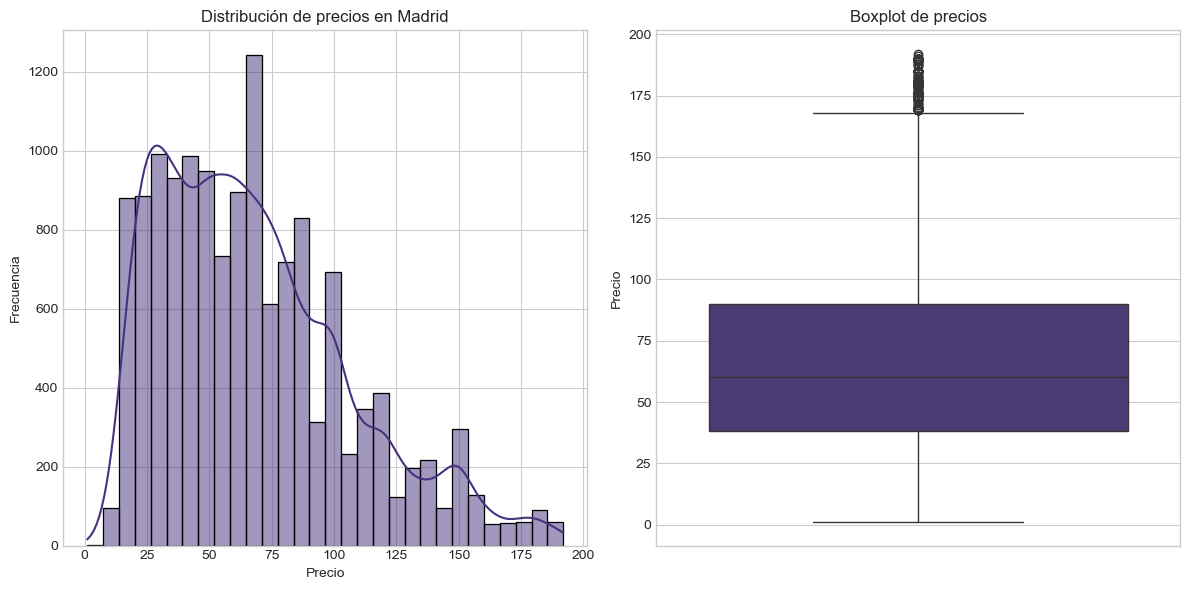

Estadísticas de precios en Madrid:
count    14085.000000
mean        67.968761
std         38.420442
min          1.000000
25%         38.000000
50%         60.000000
75%         90.000000
90%        120.000000
95%        150.000000
max        192.000000
Name: price, dtype: float64


In [13]:
# Análisis general de precios de la ciudad
plt.figure(figsize=(12, 6))

# Histograma y boxplot de precios
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribución de precios en Madrid')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'])
plt.title('Boxplot de precios')
plt.ylabel('Precio')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("Estadísticas de precios en Madrid:")
print(df['price'].describe(percentiles=[.25, .5, .75, .9, .95]))


## ¿Cómo influye en los precios la distancia a Sol?

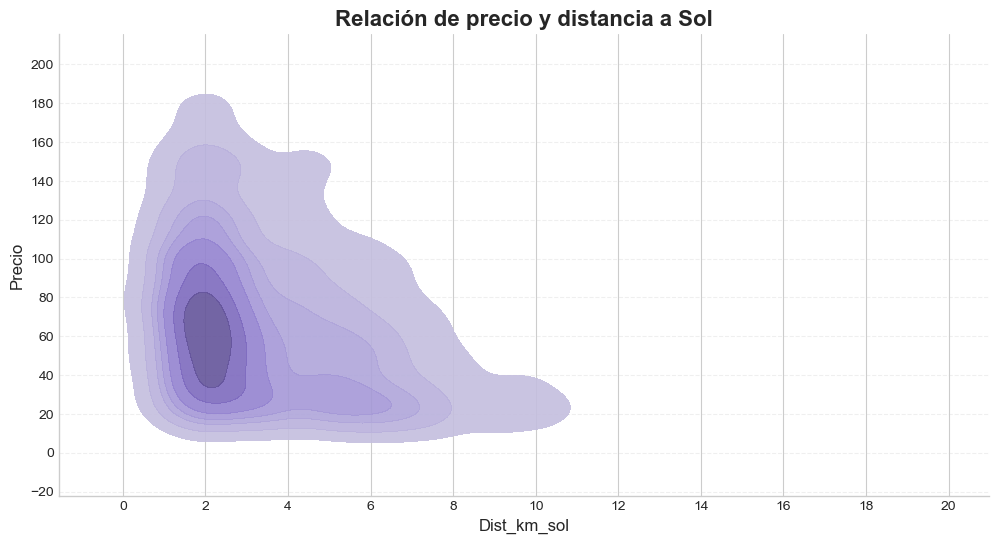

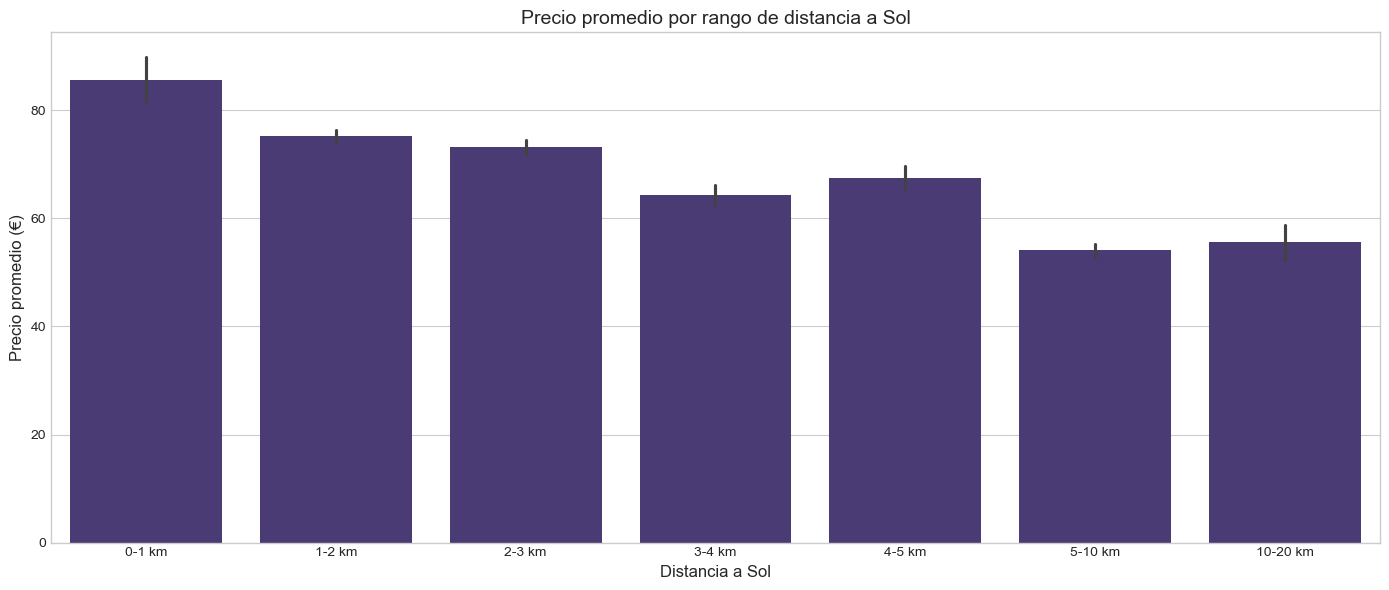

El precio medio en Madrid es: 67.97 €


,Distancia a Sol,Precio Medio (€),Comparación con Madrid
0,0-1 km,84.97,Mayor
1,1-2 km,75.16,Mayor
2,2-3 km,73.20,Mayor
3,3-4 km,64.26,Menor
4,4-5 km,67.53,Menor
5,5-6 km,57.28,Menor
6,6-7 km,54.92,Menor
7,7-8 km,49.89,Menor
8,8-9 km,49.83,Menor
9,9-10 km,47.43,Menor


In [15]:
# 1. Densidad de viviendas por precio VZ distancia en km a Sol
plt.figure(figsize=(12, 6))

# 2D density plot de precio VS distancia en km a Sol
ax = sns.kdeplot(
    data=df, 
    x="dist_km_sol", 
    y="price", 
    fill=True, 
    alpha=0.9,  
    thresh=0.1,  
    levels=8  
)

# añadir título al plot y a los ejes
ax.set_title("Relación de precio y distancia a Sol", fontsize=16, fontweight="bold")
ax.set_xlabel("Dist_km_sol", fontsize=12)
ax.set_ylabel("Precio", fontsize=12)

# personalizar el grid de fondo
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(20))
ax.grid(alpha=0.3, linestyle="--", axis="y")

# personalizar el marco del plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()
# 2. Precio promedio por distancia a Sol (agrupado)
# Creamos categorías de distancia
df['dist_category'] = pd.cut(df['dist_km_sol'], 
                            bins=[0, 1, 2, 3, 4, 5, 10, 20],
                            labels=['0-1 km', '1-2 km', '2-3 km', '3-4 km', '4-5 km', '5-10 km', '10-20 km'])

plt.figure(figsize=(14, 6))
sns.barplot(x='dist_category', y='price', data=df, estimator=np.mean)
plt.title('Precio promedio por rango de distancia a Sol', fontsize=14)
plt.xlabel('Distancia a Sol', fontsize=12)
plt.ylabel('Precio promedio (€)', fontsize=12)
plt.tight_layout()
plt.show()

# Calcular el precio medio en Madrid
precio_medio_madrid = df["price"].mean()

# Definir los rangos de distancia en intervalos de 1 km
bins_km = np.arange(0, df["dist_km_sol"].max() + 1, 1)
distancias_km = [f"{int(bins_km[i])}-{int(bins_km[i+1])} km" for i in range(len(bins_km)-1)]

# Crear columna de clasificación por distancia
df["distancia_a_Sol"] = pd.cut(df["dist_km_sol"], bins=bins_km, labels=distancias_km, right=False)

# Calcular el precio medio por cada rango de distancia
precio_medio_km = df.groupby("distancia_a_Sol")["price"].mean().round(2).reset_index()
precio_medio_km.columns = ["Distancia a Sol", "Precio Medio (€)"]

# Comparar con la media de Madrid
precio_medio_km["Comparación con Madrid"] = precio_medio_km["Precio Medio (€)"].apply(
    lambda x: "Mayor" if x > precio_medio_madrid else "Menor" if x < precio_medio_madrid else "Igual"
)

# Eliminar valores NaN
precio_medio_km = precio_medio_km.dropna()

print(f"El precio medio en Madrid es: {precio_medio_madrid:.2f} €")
# Mostrar la nueva tabla
precio_medio_km


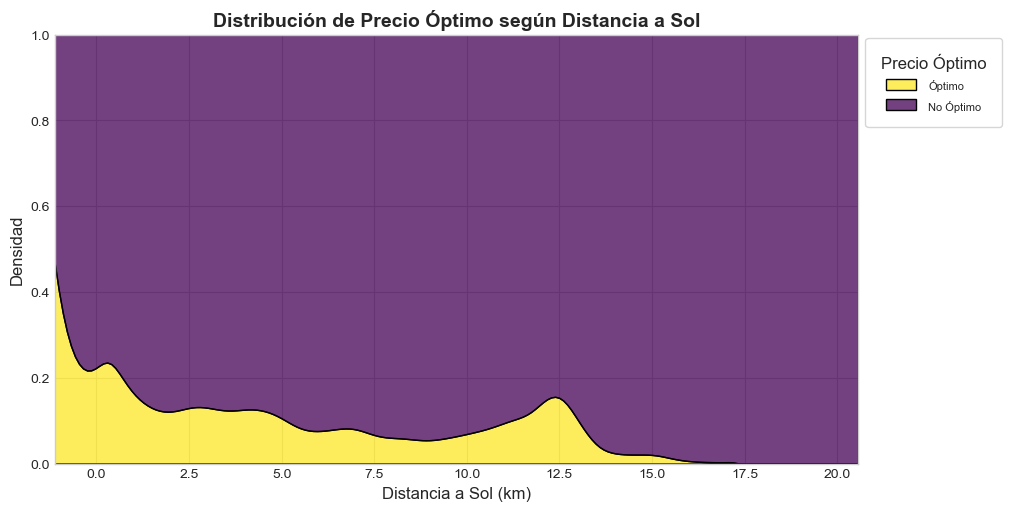

Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes rangos de distancia:
- 2-3 km: 30.80% del total
- 1-2 km: 29.55% del total
- 4-5 km: 10.05% del total


,Distancia a Sol,% Distribución Óptimos
0,0-1 km,4.605263
1,1-2 km,29.545455
2,2-3 km,30.801435
3,3-4 km,9.868421
4,4-5 km,10.047847
5,5-6 km,5.322967
6,6-7 km,4.545455
7,7-8 km,1.435407
8,8-9 km,0.837321
9,9-10 km,0.837321


In [18]:
# Crear figura
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# Paleta personalizada
paleta_personalizada = ["#440154", "#FDE725"]

# Gráfico KDE
sns.kdeplot(
    data=df,
    x="dist_km_sol",
    hue="precio_optimo",
    multiple="fill",
    palette=paleta_personalizada,
    ax=ax
)

# Títulos y etiquetas
ax.set_title("Distribución de Precio Óptimo según Distancia a Sol", fontsize=14, fontweight="bold")
ax.set_xlabel("Distancia a Sol (km)", fontsize=12)
ax.set_ylabel("Densidad", fontsize=12)

# Leyenda
leg = ax.legend(
    title="Precio Óptimo",
    labels=["Óptimo", "No Óptimo"],
    title_fontsize=12,
    fontsize=11,
    loc="upper left",
    bbox_to_anchor=(1, 1.01),
    frameon=True,
    borderpad=1,
)

# Tamaño fuente leyenda
for text in leg.get_texts():
    text.set_fontsize(8)

# Mostrar gráfico
plt.show()

# Definir los rangos de distancia en intervalos de 1 km
bins_km = np.arange(0, df["dist_km_sol"].max() + 1, 1)
distancias_km = [f"{int(bins_km[i])}-{int(bins_km[i+1])} km" for i in range(len(bins_km)-1)]

# Crear columna de clasificación por distancia
df["distancia_a_Sol"] = pd.cut(df["dist_km_sol"], bins=bins_km, labels=distancias_km, right=False)

# Calcular el porcentaje de pisos con precio óptimo por rango de distancia
distribucion_optimos = (
    df[df["precio_optimo"] == True]
    .groupby("distancia_a_Sol")["precio_optimo"]
    .count()
    .div(df["precio_optimo"].sum()) * 100
)

# Crear la tabla y eliminar valores con 0%
distribucion_precios = distribucion_optimos.reset_index()
distribucion_precios.columns = ["Distancia a Sol", "% Distribución Óptimos"]
distribucion_precios = distribucion_precios[distribucion_precios["% Distribución Óptimos"] > 0]

# Identificar las distancias con mayor concentración de pisos óptimos
top_rangos = distribucion_precios.sort_values(by="% Distribución Óptimos", ascending=False).head(3)

# Imprimir el comentario sobre la concentración
print("Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes rangos de distancia:")
for _, row in top_rangos.iterrows():
    print(f"- {row["Distancia a Sol"]}: {row['% Distribución Óptimos']:.2f}% del total")


# Mostrar la tabla
distribucion_precios